In [ ]:
# Set up feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.ethics.ex4 import *
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data, separate features from target
data = pd.read_csv("../input/synthetic-credit-card-approval/synthetic_credit_card_approval.csv")
X = data.drop(["Target"], axis=1)
y = data["Target"]

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

# Preview the data
print("Data successfully loaded!\n")
X_train.head()

In [ ]:
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train a model and make predictions
model_baseline = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)
preds_baseline = model_baseline.predict(X_test)

# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

# Function to evaluate the fairness of the model
def get_stats(X, y, model, group_one, preds):
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    print("Total approvals:", preds.sum())
    print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group A: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group B: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))
    
    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group A")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group B")
    
    print("\nSensitivity / True positive rate:")
    print("Group A: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group B: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))
    
# Evaluate the model    
get_stats(X_test, y_test, model_baseline, X_test["Group"]==1, preds_baseline)

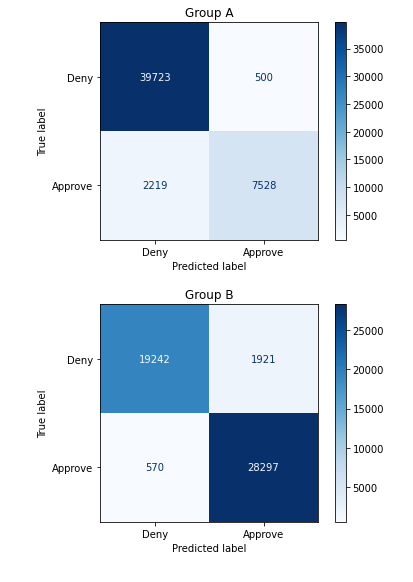

In [ ]:
def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False):
    plot_list = tree.plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
    [process_plot_item(item) for item in plot_list]

def process_plot_item(item):
    split_string = item.get_text().split("\n")
    if split_string[0].startswith("samples"):
        item.set_text(split_string[-1])
    else:
        item.set_text(split_string[0])

plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_baseline, feature_names=X_train.columns)

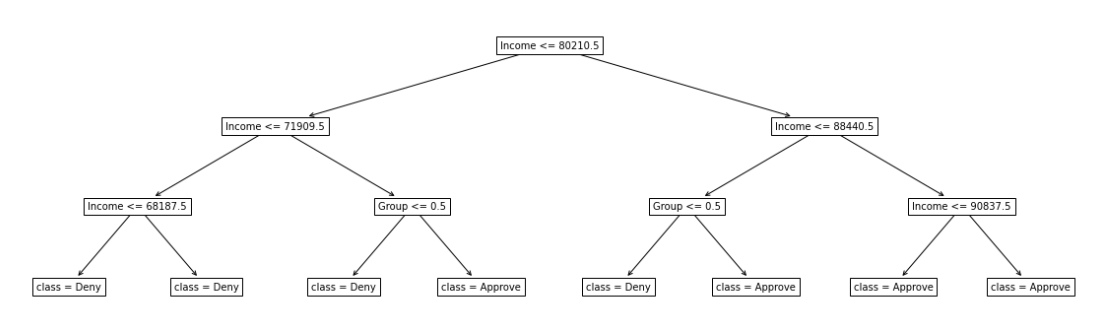

In [ ]:
# Create new dataset with gender removed
X_train_unaware = X_train.drop(["Group"],axis=1)
X_test_unaware = X_test.drop(["Group"],axis=1)

# Train new model on new dataset
model_unaware = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
model_unaware.fit(X_train_unaware, y_train)

# Evaluate the model
preds_unaware = model_unaware.predict(X_test_unaware)
get_stats(X_test_unaware, y_test, model_unaware, X_test["Group"]==1, preds_unaware)

In [ ]:
# Change the value of zero_threshold to hit the objective
zero_threshold = 0.11
one_threshold = 0.99

# Evaluate the model
test_probs = model_unaware.predict_proba(X_test_unaware)[:,1]
preds_approval = (((test_probs>zero_threshold)*1)*[X_test["Group"]==0] + ((test_probs>one_threshold)*1)*[X_test["Group"]==1])[0]
get_stats(X_test, y_test, model_unaware, X_test["Group"]==1, preds_approval)